This file is used for training in Google Colab.

### Lib import

In [1]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras
from google.colab import drive
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import sys
import pickle

drive.mount('/content/gdrive')
print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
     |████████████████████████████████| 2.4 MB 8.5 MB/s 
Mounted at /content/gdrive
TensorFlow version: 2.8.2


In [2]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Unzip files 

Unused. Because the data is directly loaded from gdrive.

In [ ]:
!unzip /acnes_and_rosacea.zip -d /tmp

unzip:  cannot find or open /acnes_and_rosacea.zip, /acnes_and_rosacea.zip.zip or /acnes_and_rosacea.zip.ZIP.


### load data dan preprocess

In [3]:
data_dir = "/content/gdrive/MyDrive/acnes_and_rosacea"

In [4]:
import tensorflow_hub as hub

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.5,
        zoom_range=0.8,
        rotation_range=90,
        horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/acnes_and_rosacea/training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)
validation_data = val_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/acnes_and_rosacea/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
test_data = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/acnes_and_rosacea/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 766 images belonging to 11 classes.
Found 80 images belonging to 11 classes.
Found 29 images belonging to 11 classes.


target size = (244, 244) mengikuti mobilenetv2 feature extractor

In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

Callback for early stopping. Monitoring accuracy with patience of 4 epochs.

### using mobile net feature extractor

In [7]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=True)

doing fine tuning

### building model and compile

In [8]:
num_classes = 11

model = tf.keras.Sequential([
  #mobilenet,
  #base_model,
  feature_extractor_layer,
  #tf.keras.layers.Flatten(),
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [9]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 11)                5643      
                                                                 
Total params: 3,182,155
Trainable params: 3,148,043
Non-

In [10]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [11]:
history = model.fit(
  train_data,
  epochs=30,
  validation_data=validation_data,
  callbacks=[callback])

Epoch 1/30
24/24 [==============================] - 274s 11s/step - loss: 2.3097 - accuracy: 0.2180 - val_loss: 2.1126 - val_accuracy: 0.3125
Epoch 2/30
24/24 [==============================] - 175s 7s/step - loss: 1.9275 - accuracy: 0.3538 - val_loss: 1.9655 - val_accuracy: 0.4000
Epoch 3/30
24/24 [==============================] - 179s 7s/step - loss: 1.7420 - accuracy: 0.4478 - val_loss: 1.8972 - val_accuracy: 0.3875
Epoch 4/30
24/24 [==============================] - 180s 7s/step - loss: 1.5280 - accuracy: 0.5157 - val_loss: 1.5775 - val_accuracy: 0.4250
Epoch 5/30
24/24 [==============================] - 186s 8s/step - loss: 1.4250 - accuracy: 0.5457 - val_loss: 1.4573 - val_accuracy: 0.5000
Epoch 6/30
24/24 [==============================] - 182s 8s/step - loss: 1.3063 - accuracy: 0.5627 - val_loss: 1.3772 - val_accuracy: 0.5625
Epoch 7/30
24/24 [==============================] - 180s 7s/step - loss: 1.2860 - accuracy: 0.5875 - val_loss: 1.3714 - val_accuracy: 0.5750
Epoch 8/30
2

### Plot history

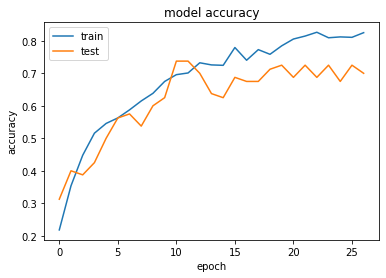

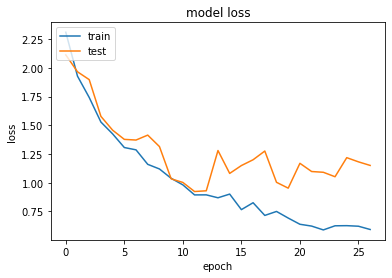

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
classes = ['acne-cystic', 'acne-excoriated', 'acne-open-comedo', 
           'acne-pustular', 'acne-scar', 'closed-comedo', 'milia',
           'perioral-dermatitis', 'Rhinophyma', 'Rosacea', 'rosacea-nose']
predictions = model.predict(test_data)
print(test_data)
prediction_array = np.argmax(predictions, axis=1)
for i in prediction_array:
  print(classes[i])

Rhinophyma
acne-excoriated
acne-excoriated
acne-excoriated
Rosacea
Rosacea
rosacea-nose
acne-pustular
Rosacea
rosacea-nose
rosacea-nose
acne-excoriated
closed-comedo
acne-excoriated
acne-pustular
acne-pustular
closed-comedo
rosacea-nose
acne-open-comedo
acne-scar
acne-scar
acne-excoriated
acne-pustular
Rosacea
rosacea-nose
acne-excoriated
acne-open-comedo
acne-excoriated
closed-comedo


### Saving model(s)

In [ ]:
from google.colab import files

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [ ]:
# Save the model
filepath = '/content/gdrive/MyDrive/saved_model0'
save_model(model, filepath)

In [ ]:
!mkdir -p /content/gdrive/MyDrive/saved_model
model.save('/content/gdrive/MyDrive/saved_model/capstone_1.2_model')
#model.save('capstone_3_model')

In [ ]:
files.download('/saved_model/capstone_7_model' + '/saved_model.pb')
#files.download('capstone_3_model')

In [ ]:
model.save('capstone_1_2_model.hdf5')

In [ ]:
files.download('capstone_1_2_model.hdf5')

In [ ]:
tf.saved_model.save(model, '/saved_model/capstone_7.1_model')

# UNUSED LINES

### unused

In [ ]:
export_dir = '/tmp/saved_model'
tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
files.download(export_dir + '/saved_model.pb')

In [ ]:
!zip "/tmp/capstone_0_model.zip" "/tmp/capstone_0_model"

In [ ]:
pickle_out = open("model.pkl", "wb")
pickle.dump(model, pickle_out)
files.download("model.pkl")
pickle_out.close()


INFO:tensorflow:Assets written to: ram://d2810cb5-3df8-4d5e-83f4-c9449f48e7fa/assets


INFO:tensorflow:Assets written to: ram://d2810cb5-3df8-4d5e-83f4-c9449f48e7fa/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Serve (unused)

In [ ]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

In [ ]:
!saved_model_cli show --dir {export_path} --all

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

In [ ]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=acne_detection \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_data[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_data)-1)
show(rando, 'An Example Image: {}'.format(classes[test_labels[rando]]))

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_data[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

### using vgg16 (unused)

In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#base_model.trainable = False ## Not trainable weights


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for (i,layer) in enumerate(base_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

### unused

In [ ]:
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

In [ ]:
mobilenet.trainable = True
print("Number of layers in the base model are: ", len(mobilenet.layers))
print("Fine tuning begins")
fine_tune_at = 152
print("Layers are frozen before 'fine_tune_at' layer")
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable = False

In [1]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224))/255.0
    return  image, label
    
test_batch = test_data.map(format_image)

NameError: ignored